# Field-level inference with GridSPT

This notebook collects all the plots and tests made for the project on field-level inference with GridSPT

Index:

- [Comparisons between different chains](#1-comparisons)
    - [$n_\text{PT}=3$, $k_\text{max}=0.1$](#1.1)
        - [$c_2(\Lambda)$](#1.1.1)
    - [$n_\text{PT}=5$, $k_\text{max}=0.1$](#1.2)
        - [$c_2(\Lambda)$](#1.2.1)
    - [$n_\text{PT}=3$, $k_\text{max}=0.2$](#1.3)
        - [$c_2(\Lambda)$](#1.3.1)
    - [$n_\text{PT}=5$, $k_\text{max}=0.2$](#1.4)
        - [$c_2(\Lambda)$](#1.4.1)
    - [Higher derivative corrections at $k_\text{max}=0.1$](#1.5)
    - [Higher derivative corrections at $k_\text{max}=0.2$](#1.6)


## Meetings

### Meeting of March 4th 2025

**NEW**

1. Refactored, optimized and fixed (hopefully) the code;
2. created this notebook;
3. running at $n_\text{PT}=3$:
    1. [click here](#npt3-kmax0.1) for the plot at $k_\text{max}=0.1$;
    2. [click here](#npt3-kmax0.2) for the plot at $k_\text{max}=0.2$.
4. Running at $n_\text{PT}=5$:
    1. [click here](#npt5-kmax0.1) for the plot at $k_\text{max}=0.1$;
    2. [click here](#npt5-kmax0.2) for the plot at $k_\text{max}=0.2$.
5. Higher derivative terms for 2 different $\Lambda=0.3,\,0.5$ and $n_\text{PT}=3,\,5$ at $k_\text{max}=0.1$ ([click here](#highder-kmax0.1)) and at $k_\text{max}=0.2$ ([click here](#highder-kmax0.2)). From the plots the term $c_{\delta^{(2)}}$ seems highly relevant for correcting the running, and the others also seems to have an effect for smaller $k_\text{max}$.

**TODO**

1. Repeat old chains with $A$;
2. repeat old chains with different shot noise realization;
3. do chain with only $c_{\delta^{(2)}}$;
4. do chain with higher derivative terms at $k_\text{max}=0.15$;
5. repeat chains on Takahiro's high res simulation to see if it yields non-zero values of $c_2$.

### Meeting of March 17th 2025

**NEW**

TBD

**TODO**

TBD

## Imports, functions and globals

In [15]:
import Pk_library as PKL

import run_chains, generate_fields

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


ModuleNotFoundError: No module named 'Pk_library'

In [1]:
# imports

import yaml, os
import numpy as np
import matplotlib.pyplot as plt

from getdist import plots, loadMCSamples

from IPython.display import display, HTML

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

project_path = "/hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out"

# plot variables

default_triangle_plot = {
    "markers": {
        "epsag2": -0.0008
    },
    "title_limit": 1,
}
colors = [
        (240/255, 163/255, 255/255),
        (0/255, 117/255, 220/255),
        (153/255, 63/255, 0/255),
        (76/255, 0/255 ,92/255),
        (25/255, 25/255, 25/255),
        (0/255, 92/255, 49/255),
        (43/255, 206/255, 72/255),
        (255/255, 204/255, 153/255),
        (128/255, 128/255, 128/255),
        (148/255, 255/255, 181/255),
        (143/255, 124/255, 0/255),
        (157/255, 204/255, 0/255),
        (194/255, 0/255 ,136/255),
        (0/255, 51/255, 128/255),
        (255/255, 164/255, 5/255),
        (255/255, 168/255, 187/255),
        (66/255, 102/255, 0/255),
        (255/255, 0/255 ,16/255),
        (94/255, 241/255, 242/255),
        (0/255, 153/255, 143/255),
        (224/255, 255/255, 102/255),
        (116/255, 10/255, 255/255),
        (153/255, 0/255, 0/255),
        (255/255, 255/255, 128/255),
        (255/255, 255/255, 0/255),
        (255/255, 80/255, 5/255)
    ]

In [4]:
# functions

def get_input_file_from_chain(output_filename):

    return output_filename.replace("output", "input")+".yaml"

def get_chain_from_input_file(input_filename):

    return input_filename.replace("input", "output").replace(".yaml", "")

def unpack_dict_to_str(d, level=0):

    fmt = ""
    for k, v in d.items():
        if type(v) is dict:
            fmt += 2*level*" "+f"{k}: \n"
            fmt += unpack_dict_to_str(v, level+1)
        else:
            fmt += 2*level*" "+f"{k}: {v}\n"

    return fmt
            
def parse_yaml(f):

    return yaml.safe_load(open(f, "r"))
    
def get_info(f):

    parameters = parse_yaml(f)

    return unpack_dict_to_str(parameters)

def get_datestr(filename):

    if "output" in filename:
        return filename.split("_")[-1]
    else:
        return filename.split("_")[-1].split(".")[0]

def browse_chains(start=None, stop=None, query=None):
    # outputs all the chains in cronological order
    # start, stop : int in YYYYMMDDhhmm
    # query : dict of parameters to be matched in the yaml file. If a key has value 'None' the search will match only the key regardless of value

    def find_key_in_dict(d, queried_key, queried_value=None, level=0):
        
        matches = []
        for k, v in d.items():
            if k==queried_key:
                if v==queried_value or queried_value is None:
                    if type(v) is dict:
                        matches.append(f"{k}: {{\n{unpack_dict_to_str(v)}}}")
                    else:
                        matches.append(f"{k}: {v}")

            
            if type(v) is dict:
                match = f"{k} > "
                deep_match = find_key_in_dict(v, queried_key, queried_value, level+1)
                for m in deep_match:
                    matches.append(match+m)

        return matches
    
    if start is None and stop is not None:
        check_datestr = lambda datestr: int(get_datestr(datestr))<=stop
        start = "the beginning of time"
    elif start is not None and stop is None:
        check_datestr = lambda datestr: start<=int(get_datestr(datestr))
        stop = "the end of time"
    elif start is not None and stop is not None:
        check_datestr = lambda datestr: start<=int(get_datestr(datestr))<=stop
    else:
        check_datestr = lambda datestr: True
        start, stop = "the beginning of time", "the end of time"
    
    files = [(get_datestr(i), i) for i in os.listdir(project_path) if "output" in i and check_datestr(i)]
    _, files = zip(*sorted(files))
    if query is not None:
        found = []
        
        for i, f in enumerate(files):
            print(f"searching file {i+1} of {len(files)}", end="\r")
            p = parse_yaml(f"{project_path}/{f}/{get_input_file_from_chain(f)}")
            query_matched = False
            
            for k, v in query.items():
                matches = find_key_in_dict(p, k, v)
                if len(matches)!=0:
                    query_matched = True
                else:
                    query_matched = False
                    break

            if query_matched:
                found.append(f)

        print("")
        print(f"Search between {start} and {stop} with the following query:\n"
              f"{unpack_dict_to_str(query)}"
              "yielded the following files:\n")
        print("\n".join(found))

        return found
    else:
        print(f"Search between {start} and {stop} yielded the following files:\n")
        print("\n".join(files))

        return files

def get_value_of_key_in_dict(d, key, level=0):

    matches = []
    for k, v in d.items():
        if k==key:
            matches.append((level, v))
            
        if type(v) is dict:
            matches.append(get_value_of_key_in_dict(v, key, level+1))

    return matches

def sort_from_key(files, key, key_instance_index=0):

    def flatten_list(l):

        flat = []
        for el in l:
            if type(el) is list:
                subl = flatten_list(el)
                for subel in subl:
                    flat.append(subel)
            else:
                flat.append(el)

        return flat

    combined = []
    for f in files:
        pars = parse_yaml(f"{project_path}/{f}/{get_input_file_from_chain(f)}")

        v = get_value_of_key_in_dict(pars, key)
        v = flatten_list(v)
        assert v, f"No instance of '{key}' found in {f}. If this is ok, remove it from the list and rerun."
        if len(v)>1:
            print(f"Warning: using instance {key_instance_index} out of {len(v)} of '{key}' for sorting.")
            for i, inst in enumerate(v):
                print((1 if i==key_instance_index else 0)*"> "+f"{inst} (level, value)")

        v = v[key_instance_index][-1]
        assert isinstance(v, (int, float)), f"The key to sort the list must be an integer or a real number, instead of {type(v)}."

        combined.append((v, f))
    
    sorted_values, sorted_files = zip(*sorted(combined))

    return sorted_values, sorted_files

def chain_plot(**plot_data):

    settings = plots.GetDistPlotSettings()
    settings.legend_fontsize = "x-small"
    settings.figure_legend_frame = False
    # settings.tight_layout = True
    # settings.constrained_layout = True
    g = plots.get_subplot_plotter(settings=settings)

    for chain, input in zip(plot_data["roots"], plot_data["input_files"]):
        print(f"plotting chain {chain.root}")
        print(f"--- INPUT {input} ---")
        print("")
        print(get_info(input))
        
    g.triangle_plot(**plot_data)
    

## 1 Comparisons

In [5]:
# browse all chains

_ = browse_chains()

Search between the beginning of time and the end of time yielded the following files:

field-level-inference-GridSPT_output_202502251617
field-level-inference-GridSPT_output_202503031150
field-level-inference-GridSPT_output_202503031156
field-level-inference-GridSPT_output_202503031248
field-level-inference-GridSPT_output_202503031620
field-level-inference-GridSPT_output_202503031622
field-level-inference-GridSPT_output_202503031624
field-level-inference-GridSPT_output_202503031628
field-level-inference-GridSPT_output_202503031656
field-level-inference-GridSPT_output_202503031657
field-level-inference-GridSPT_output_202503031658
field-level-inference-GridSPT_output_202503031659
field-level-inference-GridSPT_output_202503031700
field-level-inference-GridSPT_output_202503031701
field-level-inference-GridSPT_output_202503031702
field-level-inference-GridSPT_output_202503031703
field-level-inference-GridSPT_output_202503031743
field-level-inference-GridSPT_output_202503031745
field-level-i

### 1.1 Running with $\Lambda$ at $n_\text{PT}=3$, $k_\text{max}=0.1$

In [53]:
# for linking
display(HTML("<div id=\"1.1\"></div>"))

# find chains correponding to parameters and sort them with Lambda

query = {
    "nPT": 3,
    "kmax": 0.1,
    "model": "EFT" # only consider chains ran with only c_s^2-like counterterm in the model
}
chains = browse_chains(
    query = query
)
Lambdas, chains = sort_from_key(chains, "Lambda") # sort list based on Lambda

searching file 38 of 38
Search between the beginning of time and the end of time with the following query:
nPT: 3
kmax: 0.1
model: EFT
yielded the following files:

field-level-inference-GridSPT_output_202502251617
field-level-inference-GridSPT_output_202503031150
field-level-inference-GridSPT_output_202503031156
field-level-inference-GridSPT_output_202503031248
field-level-inference-GridSPT_output_202503031620
field-level-inference-GridSPT_output_202503031622
field-level-inference-GridSPT_output_202503031624
field-level-inference-GridSPT_output_202503031628


plotting chain /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202502251617/chain
--- INPUT /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202502251617/field-level-inference-GridSPT_input_202502251617.yaml ---

README: "This is the input file containing all the information about a single execution of the project 'field-level-inference-GridSPT'.""
""
"The file is structured as follows:"
""
"  - `gridspt_fields` contains all the information about the fields generated by GridSPT;"
"  - `nbody_field_input` contains all the information about the fields generated from an N-body simulation;"
"  - `nbody_field_output` contains all the information about the N-body snapshot used to generate N-body fields;"
"  - `chain` contains all the information about the chains or optimizations to be run between N-body fields and GridSPT fields"
"  - `DEBUG` contains the flag to control debuggi

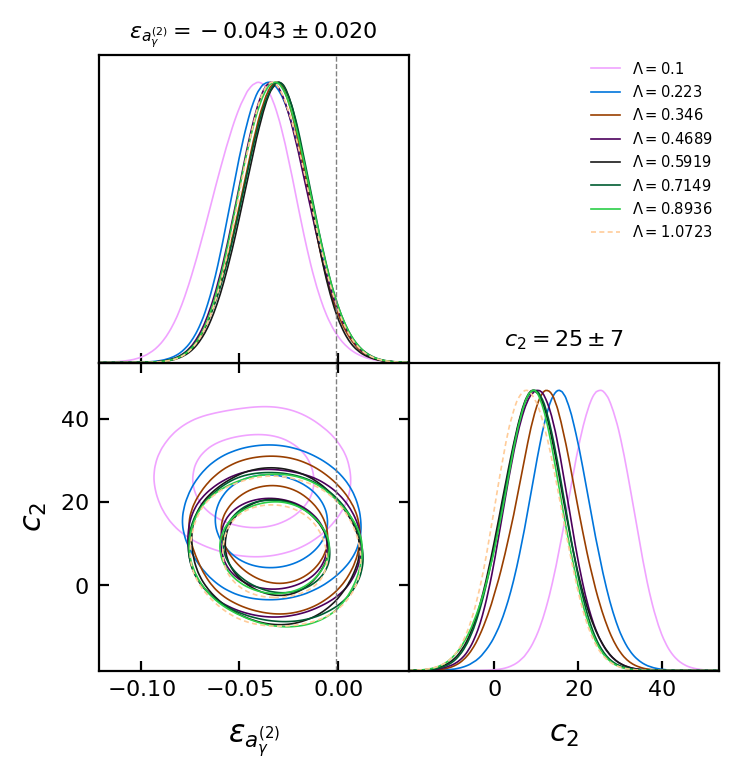

In [42]:
chain_plot_data = {
    "input_files": [],
    "roots": [],
    "legend_labels": [],
    "line_args": [], 
    "contour_args": [],
    **default_triangle_plot
}

for i, (Lambda, chain) in enumerate(zip(Lambdas, chains)):
    chain_plot_data["input_files"].append(f"{project_path}/{chain}/{get_input_file_from_chain(chain)}")
    chain_plot_data["roots"].append(loadMCSamples(f"{project_path}/{chain}/chain"))
    chain_plot_data["legend_labels"].append(rf"$\Lambda={Lambda}$")
    chain_plot_data["line_args"].append({"color": colors[i]})
    chain_plot_data["contour_args"].append({"color": colors[i]})

chain_plot(**chain_plot_data)

# for linking
display(HTML("<div id=\"npt3-kmax0.1\"></div>"))

#### 1.1.1 $c_2(\Lambda)$ running

In [ ]:
# for linking
display(HTML("<div id=\"1.1.1\"></div>"))

# get best fit values of c_2 as function of Lambda

burnin = 0.3 # fraction to discard
print(f"{'Lambda':>11} {'c_2 (mean)':>11} {'c_2 (16%)':>11} {'c_2 (84%)':>11}")
for Lambda, chain in zip(Lambdas, chain_plot_data["roots"]):
    # get c_2 chain (index 1)
    samples = chain.samples[:, 1]
    samples = samples[int(burnin*len(samples)):]
    
    print(f"{Lambda:11.4f} {np.mean(samples):11.6f} {np.quantile(samples, 0.16):11.6f} {np.quantile(samples, 0.84):11.6f}")

     Lambda  c_2 (mean)   c_2 (16%)   c_2 (84%)
     0.1000   24.795837   15.603481   33.752841
     0.2230   15.244453    5.784550   25.050191
     0.3460   12.546298    2.654637   22.230030
     0.4689   10.243132    1.297977   19.235875
     0.5919    9.225343   -0.789290   18.965268
     0.7149    9.188942   -0.000342   18.124096
     0.8936    8.621625   -0.564778   17.754275
     1.0723    8.068657   -1.223245   17.601112


### 1.2 Running with $\Lambda$ at $n_\text{PT}=5$, $k_\text{max}=0.1$

In [ ]:
# for linking
display(HTML("<div id=\"1.2.1\"></div>"))

# find chains correponding to parameters and sort them with Lambda

query = {
    "nPT": 5,
    "kmax": 0.1,
    "model": "EFT" # only consider chains ran with only c_s^2-like counterterm in the model
}
chains = browse_chains(
    query = query
)
Lambdas, chains = sort_from_key(chains, "Lambda") # sort list based on Lambda

searching file 38 of 38
Search between the beginning of time and the end of time with the following query:
nPT: 5
kmax: 0.1
model: EFT
yielded the following files:

field-level-inference-GridSPT_output_202503031656
field-level-inference-GridSPT_output_202503031657
field-level-inference-GridSPT_output_202503031658
field-level-inference-GridSPT_output_202503031659
field-level-inference-GridSPT_output_202503031700
field-level-inference-GridSPT_output_202503031701
field-level-inference-GridSPT_output_202503031702
field-level-inference-GridSPT_output_202503031703


plotting chain /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031700/chain
--- INPUT /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031700/field-level-inference-GridSPT_input_202503031700.yaml ---

README: "This is the input file containing all the information about a single execution of the project 'field-level-inference-GridSPT'.""
""
"The file is structured as follows:"
""
"  - `gridspt_fields` contains all the information about the fields generated by GridSPT;"
"  - `nbody_field_input` contains all the information about the fields generated from an N-body simulation;"
"  - `nbody_field_output` contains all the information about the N-body snapshot used to generate N-body fields;"
"  - `chain` contains all the information about the chains or optimizations to be run between N-body fields and GridSPT fields"
"  - `DEBUG` contains the flag to control debuggi

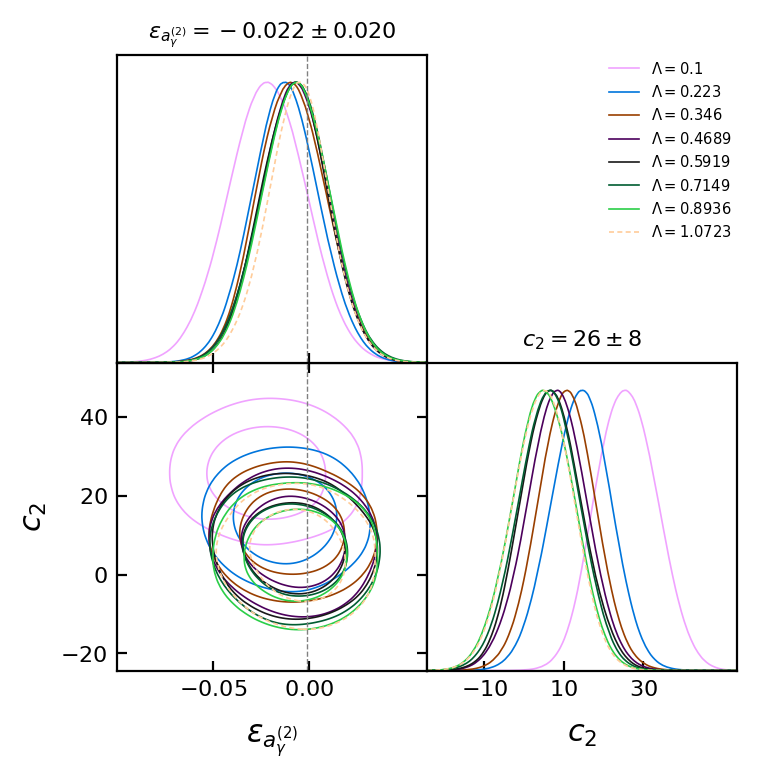

In [45]:
chain_plot_data = {
    "input_files": [],
    "roots": [],
    "legend_labels": [],
    "line_args": [], 
    "contour_args": [],
    **default_triangle_plot
}

for i, (Lambda, chain) in enumerate(zip(Lambdas, chains)):
    chain_plot_data["input_files"].append(f"{project_path}/{chain}/{get_input_file_from_chain(chain)}")
    chain_plot_data["roots"].append(loadMCSamples(f"{project_path}/{chain}/chain"))
    chain_plot_data["legend_labels"].append(rf"$\Lambda={Lambda}$")
    chain_plot_data["line_args"].append({"color": colors[i]})
    chain_plot_data["contour_args"].append({"color": colors[i]})

chain_plot(**chain_plot_data)

# for linking
display(HTML("<div id=\"npt5-kmax0.1\"></div>"))

#### 1.2.1 $c_2(\Lambda)$ running

In [ ]:
# for linking
display(HTML("<div id=\"1.2.1\"></div>"))

# get best fit values of c_2 as function of Lambda

burnin = 0.3 # fraction to discard
print(f"{'Lambda':>11} {'c_2 (mean)':>11} {'c_2 (16%)':>11} {'c_2 (84%)':>11}")
for Lambda, chain in zip(Lambdas, chain_plot_data["roots"]):
    # get c_2 chain (index 1)
    samples = chain.samples[:, 1]
    samples = samples[int(burnin*len(samples)):]
    
    print(f"{Lambda:11.4f} {np.mean(samples):11.6f} {np.quantile(samples, 0.16):11.6f} {np.quantile(samples, 0.84):11.6f}")

     Lambda  c_2 (mean)   c_2 (16%)   c_2 (84%)
     0.1000   25.595280   16.350024   35.083318
     0.2230   14.180779    4.789472   23.362036
     0.3460   10.772674    1.810580   19.776543
     0.4689    7.976461   -2.379806   17.762989
     0.5919    6.913766   -2.812192   16.855807
     0.7149    5.828578   -4.081234   15.817354
     0.8936    4.700245   -5.103122   14.295007
     1.0723    4.795538   -4.946065   14.681677


### 1.3 Running with $\Lambda$ at $n_\text{PT}=3$, $k_\text{max}=0.2$

In [ ]:
# for linking
display(HTML("<div id=\"1.3\"></div>"))

# find chains correponding to parameters and sort them with Lambda

query = {
    "nPT": 3,
    "kmax": 0.2,
    "model": "EFT" # only consider chains ran with only c_s^2-like counterterm in the model
}
chains = browse_chains(
    query = query
)
Lambdas, chains = sort_from_key(chains, "Lambda") # sort list based on Lambda

searching file 38 of 38
Search between the beginning of time and the end of time with the following query:
nPT: 3
kmax: 0.2
model: EFT
yielded the following files:

field-level-inference-GridSPT_output_202503031743
field-level-inference-GridSPT_output_202503031745
field-level-inference-GridSPT_output_202503031746
field-level-inference-GridSPT_output_202503031748
field-level-inference-GridSPT_output_202503031750
field-level-inference-GridSPT_output_202503031751
field-level-inference-GridSPT_output_202503031756


plotting chain /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031746/chain
--- INPUT /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031746/field-level-inference-GridSPT_input_202503031746.yaml ---

README: "This is the input file containing all the information about a single execution of the project 'field-level-inference-GridSPT'.""
""
"The file is structured as follows:"
""
"  - `gridspt_fields` contains all the information about the fields generated by GridSPT;"
"  - `nbody_field_input` contains all the information about the fields generated from an N-body simulation;"
"  - `nbody_field_output` contains all the information about the N-body snapshot used to generate N-body fields;"
"  - `chain` contains all the information about the chains or optimizations to be run between N-body fields and GridSPT fields"
"  - `DEBUG` contains the flag to control debuggi

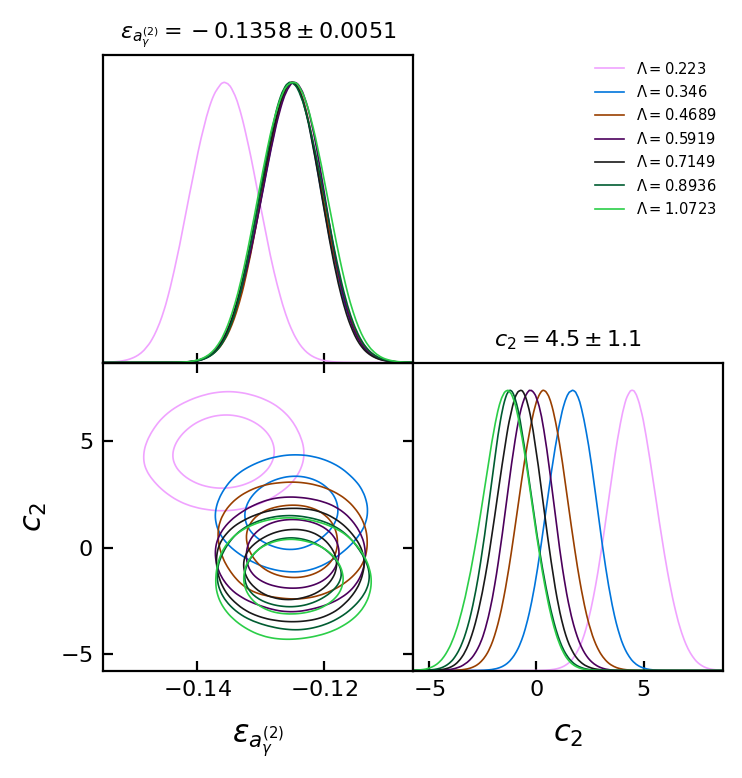

In [48]:
chain_plot_data = {
    "input_files": [],
    "roots": [],
    "legend_labels": [],
    "line_args": [], 
    "contour_args": [],
    **default_triangle_plot
}

for i, (Lambda, chain) in enumerate(zip(Lambdas, chains)):
    chain_plot_data["input_files"].append(f"{project_path}/{chain}/{get_input_file_from_chain(chain)}")
    chain_plot_data["roots"].append(loadMCSamples(f"{project_path}/{chain}/chain"))
    chain_plot_data["legend_labels"].append(rf"$\Lambda={Lambda}$")
    chain_plot_data["line_args"].append({"color": colors[i]})
    chain_plot_data["contour_args"].append({"color": colors[i]})

chain_plot(**chain_plot_data)

# for linking
display(HTML("<div id=\"npt3-kmax0.2\"></div>"))

#### 1.3.1 $c_2(\Lambda)$ running

In [ ]:
# for linking
display(HTML("<div id=\"1.3.1\"></div>"))

# get best fit values of c_2 as function of Lambda

burnin = 0.3 # fraction to discard
print(f"{'Lambda':>11} {'c_2 (mean)':>11} {'c_2 (16%)':>11} {'c_2 (84%)':>11}")
for Lambda, chain in zip(Lambdas, chain_plot_data["roots"]):
    # get c_2 chain (index 1)
    samples = chain.samples[:, 1]
    samples = samples[int(burnin*len(samples)):]
    
    print(f"{Lambda:11.4f} {np.mean(samples):11.6f} {np.quantile(samples, 0.16):11.6f} {np.quantile(samples, 0.84):11.6f}")

     Lambda  c_2 (mean)   c_2 (16%)   c_2 (84%)
     0.2230    4.532231    3.059715    6.068199
     0.3460    1.660053    0.134443    3.172409
     0.4689    0.353193   -1.171631    1.887412
     0.5919   -0.296073   -1.739594    1.171450
     0.7149   -0.800692   -2.331327    0.626977
     0.8936   -1.142039   -2.594117    0.378406
     1.0723   -1.444572   -3.047592    0.084284


### 1.4 Running with $\Lambda$ at $n_\text{PT}=5$, $k_\text{max}=0.2$

In [ ]:
# for linking
display(HTML("<div id=\"1.4\"></div>"))

# find chains correponding to parameters and sort them with Lambda

query = {
    "nPT": 5,
    "kmax": 0.2,
    "model": "EFT" # only consider chains ran with only c_s^2-like counterterm in the model
}
chains = browse_chains(
    query = query
)
Lambdas, chains = sort_from_key(chains, "Lambda") # sort list based on Lambda

searching file 38 of 38
Search between the beginning of time and the end of time with the following query:
nPT: 5
kmax: 0.2
model: EFT
yielded the following files:

field-level-inference-GridSPT_output_202503031747
field-level-inference-GridSPT_output_202503031752
field-level-inference-GridSPT_output_202503031753
field-level-inference-GridSPT_output_202503031754
field-level-inference-GridSPT_output_202503031755
field-level-inference-GridSPT_output_202503031757
field-level-inference-GridSPT_output_202503031758


plotting chain /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031758/chain
--- INPUT /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031758/field-level-inference-GridSPT_input_202503031758.yaml ---

README: "This is the input file containing all the information about a single execution of the project 'field-level-inference-GridSPT'.""
""
"The file is structured as follows:"
""
"  - `gridspt_fields` contains all the information about the fields generated by GridSPT;"
"  - `nbody_field_input` contains all the information about the fields generated from an N-body simulation;"
"  - `nbody_field_output` contains all the information about the N-body snapshot used to generate N-body fields;"
"  - `chain` contains all the information about the chains or optimizations to be run between N-body fields and GridSPT fields"
"  - `DEBUG` contains the flag to control debuggi

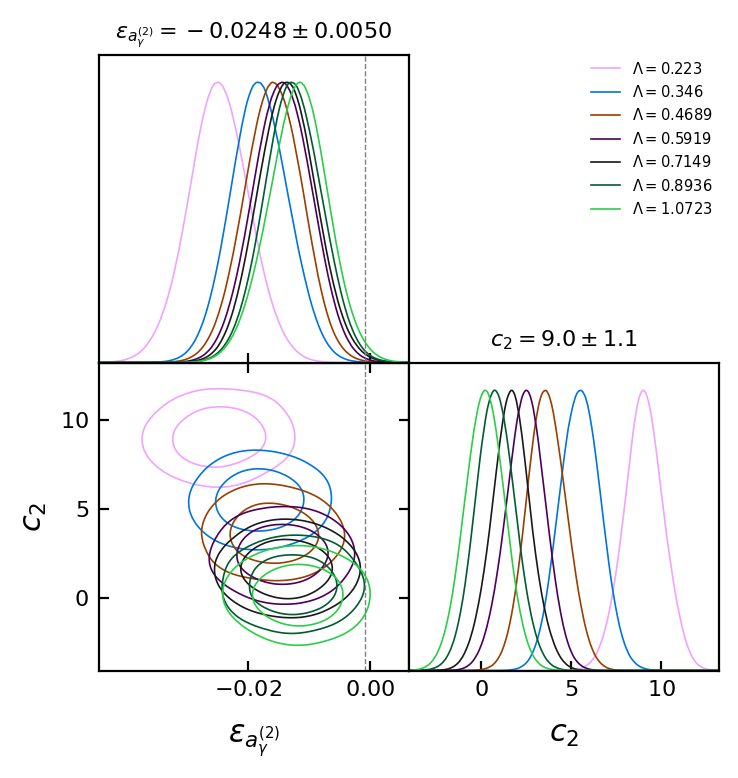

In [51]:
chain_plot_data = {
    "input_files": [],
    "roots": [],
    "legend_labels": [],
    "line_args": [], 
    "contour_args": [],
    **default_triangle_plot
}

for i, (Lambda, chain) in enumerate(zip(Lambdas, chains)):
    chain_plot_data["input_files"].append(f"{project_path}/{chain}/{get_input_file_from_chain(chain)}")
    chain_plot_data["roots"].append(loadMCSamples(f"{project_path}/{chain}/chain"))
    chain_plot_data["legend_labels"].append(rf"$\Lambda={Lambda}$")
    chain_plot_data["line_args"].append({"color": colors[i]})
    chain_plot_data["contour_args"].append({"color": colors[i]})

chain_plot(**chain_plot_data)

# for linking
display(HTML("<div id=\"npt5-kmax0.2\"></div>"))

#### 1.4.1 $c_2(\Lambda)$ running

In [ ]:
# for linking
display(HTML("<div id=\"1.4.1\"></div>"))

# get best fit values of c_2 as function of Lambda

burnin = 0.3 # fraction to discard
print(f"{'Lambda':>11} {'c_2 (mean)':>11} {'c_2 (16%)':>11} {'c_2 (84%)':>11}")
for Lambda, chain in zip(Lambdas, chain_plot_data["roots"]):
    # get c_2 chain (index 1)
    samples = chain.samples[:, 1]
    samples = samples[int(burnin*len(samples)):]
    
    print(f"{Lambda:11.4f} {np.mean(samples):11.6f} {np.quantile(samples, 0.16):11.6f} {np.quantile(samples, 0.84):11.6f}")

     Lambda  c_2 (mean)   c_2 (16%)   c_2 (84%)
     0.2230    9.024597    7.548194   10.625599
     0.3460    5.508882    3.917971    7.128598
     0.4689    3.615653    2.134347    5.252257
     0.5919    2.372353    0.797598    3.900861
     0.7149    1.690996    0.181788    3.225257
     0.8936    0.767347   -0.751868    2.310540
     1.0723    0.162871   -1.400180    1.734232


### 1.5 Higher derivative terms at $k_\text{max}=0.1$ for different $n_\text{PT}$ and $\Lambda$

In [ ]:
# for linking
display(HTML("<div id=\"1.5\"></div>"))

# first find chains correponding to nPT=3 and sort them with Lambda
# then do the same with nPT=5

query = {
    "nPT": 3,
    "kmax": 0.1,
    "model": "high_der" # only consider chains ran with higher derivative model
}
chains1 = browse_chains(
    query = query
)
Lambdas1, chains1 = sort_from_key(chains1, "Lambda") # sort list based on Lambda

query = {
    "nPT": 5,
    "kmax": 0.1,
    "model": "high_der" # only consider chains ran with higher derivative model
}
chains2 = browse_chains(
    query = query
)
Lambdas2, chains2 = sort_from_key(chains2, "Lambda") # sort list based on Lambda

searching file 38 of 38
Search between the beginning of time and the end of time with the following query:
nPT: 3
kmax: 0.1
model: high_der
yielded the following files:

field-level-inference-GridSPT_output_202503031801
field-level-inference-GridSPT_output_202503031802
searching file 38 of 38
Search between the beginning of time and the end of time with the following query:
nPT: 5
kmax: 0.1
model: high_der
yielded the following files:

field-level-inference-GridSPT_output_202503031803
field-level-inference-GridSPT_output_202503031804


plotting chain /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031801/chain
--- INPUT /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031801/field-level-inference-GridSPT_input_202503031801.yaml ---

README: "This is the input file containing all the information about a single execution of the project 'field-level-inference-GridSPT'.""
""
"The file is structured as follows:"
""
"  - `gridspt_fields` contains all the information about the fields generated by GridSPT;"
"  - `nbody_field_input` contains all the information about the fields generated from an N-body simulation;"
"  - `nbody_field_output` contains all the information about the N-body snapshot used to generate N-body fields;"
"  - `chain` contains all the information about the chains or optimizations to be run between N-body fields and GridSPT fields"
"  - `DEBUG` contains the flag to control debuggi

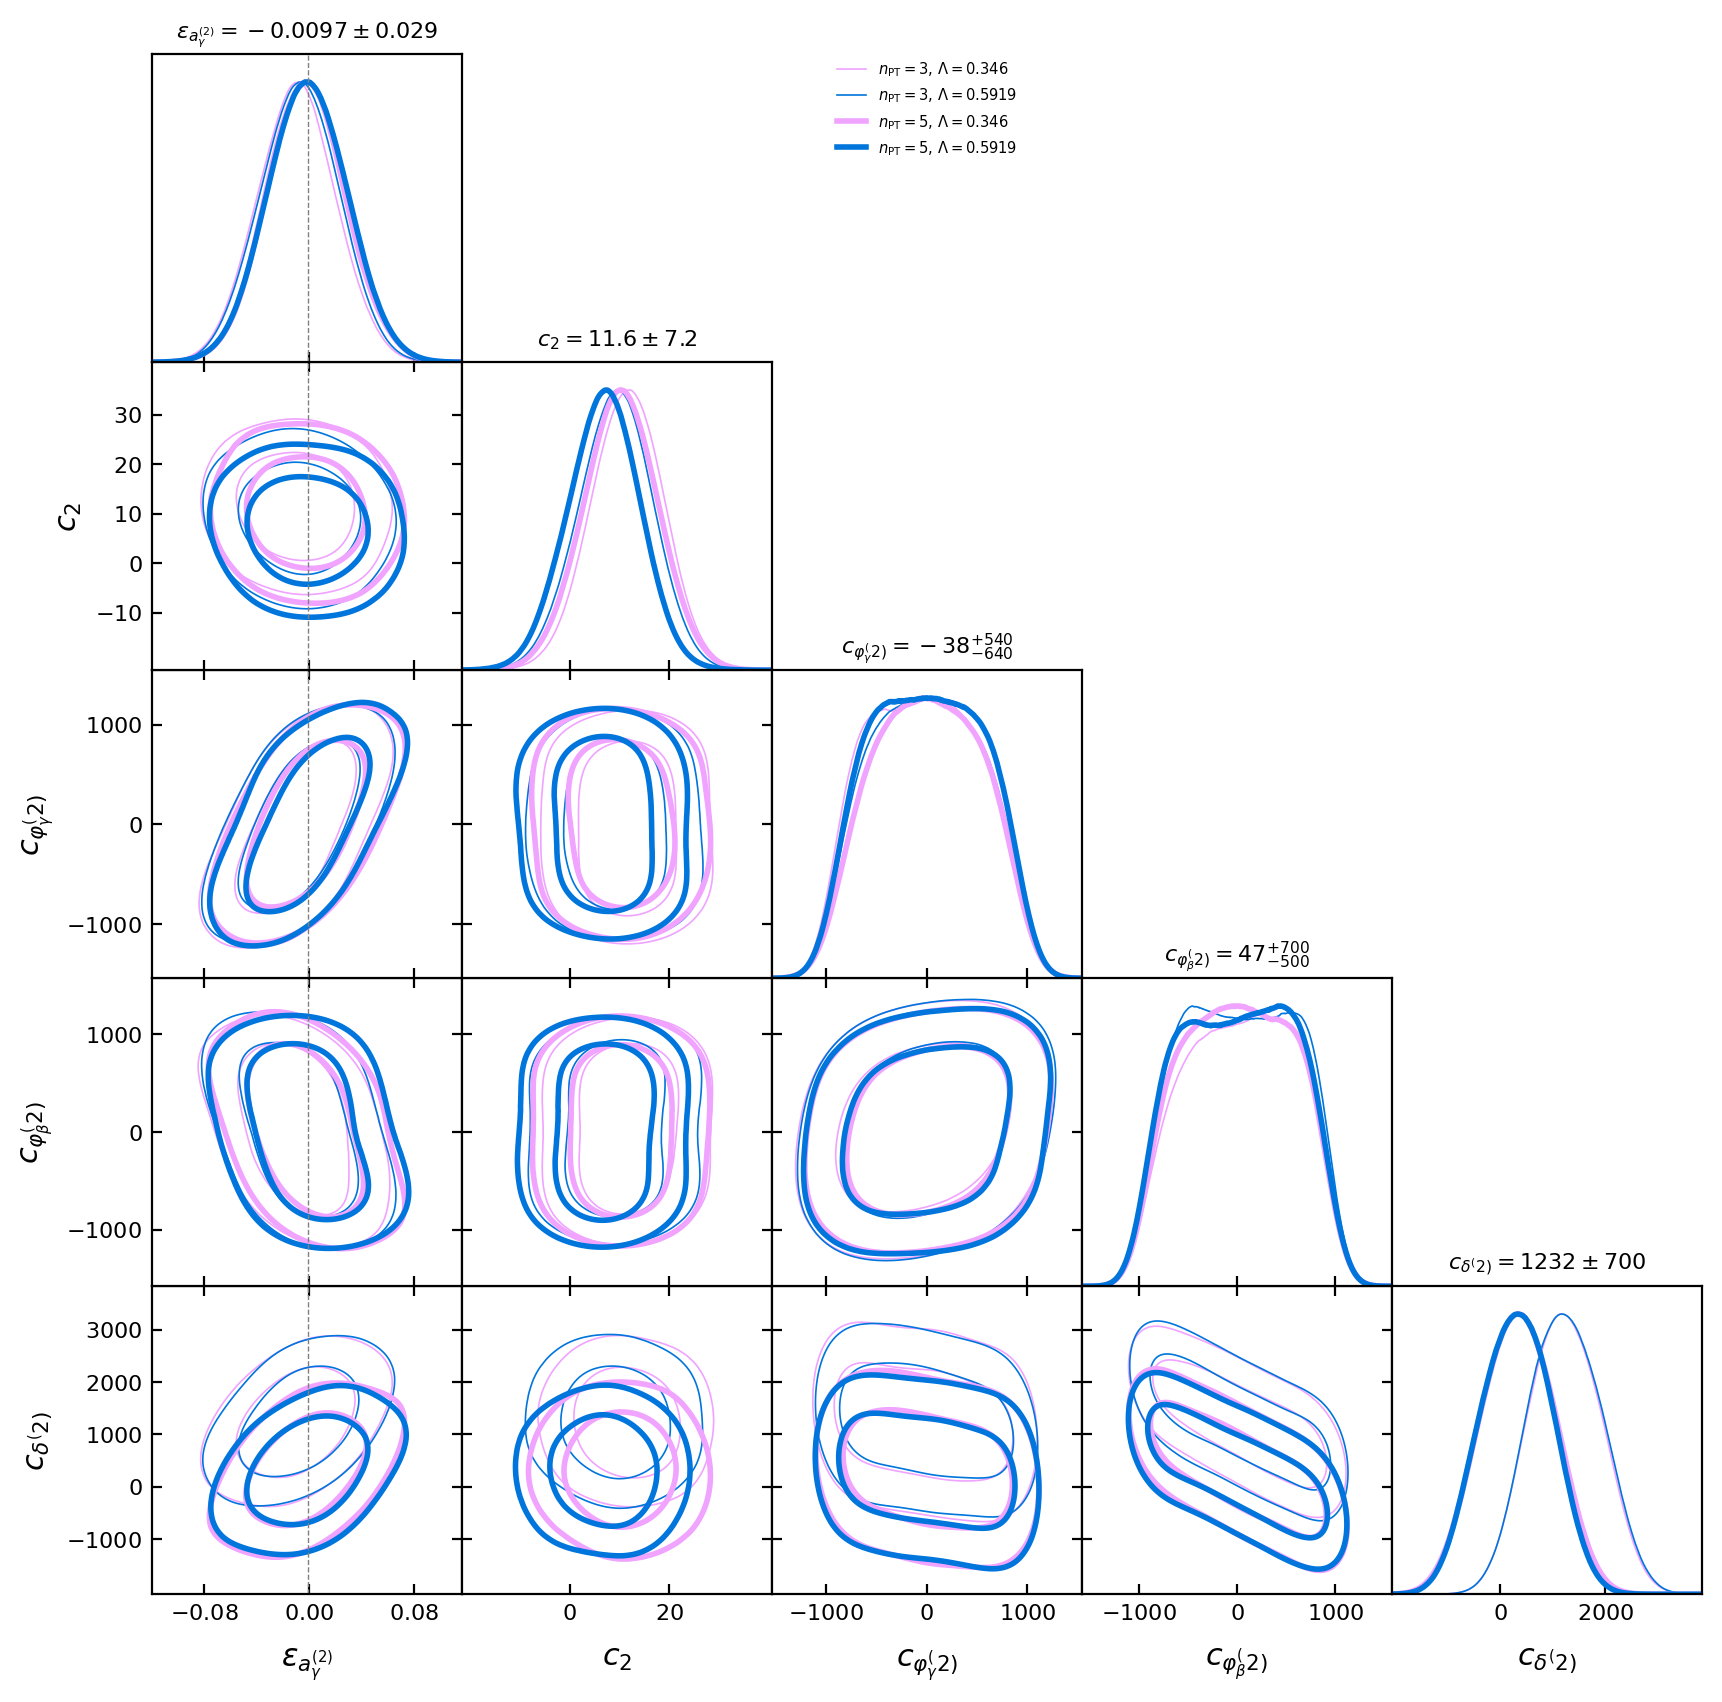

In [29]:
chain_plot_data = {
    "input_files": [],
    "roots": [],
    "legend_labels": [],
    "line_args": [], 
    "contour_args": [],
    **default_triangle_plot
}

for i, (Lambda, chain) in enumerate(zip(Lambdas1, chains1)):
    chain_plot_data["input_files"].append(f"{project_path}/{chain}/{get_input_file_from_chain(chain)}")
    chain_plot_data["roots"].append(loadMCSamples(f"{project_path}/{chain}/chain"))
    chain_plot_data["legend_labels"].append(rf"$n_\text{{PT}}=3$, $\Lambda={Lambda}$")
    chain_plot_data["line_args"].append({"color": colors[i]})
    chain_plot_data["contour_args"].append({"color": colors[i]})

for i, (Lambda, chain) in enumerate(zip(Lambdas2, chains2)):
    chain_plot_data["input_files"].append(f"{project_path}/{chain}/{get_input_file_from_chain(chain)}")
    chain_plot_data["roots"].append(loadMCSamples(f"{project_path}/{chain}/chain"))
    chain_plot_data["legend_labels"].append(rf"$n_\text{{PT}}=5$, $\Lambda={Lambda}$")
    chain_plot_data["line_args"].append({
        "color": colors[i],
        "lw": 2
    })
    chain_plot_data["contour_args"].append({
        "color": colors[i],
        "lw": 2
    })

chain_plot(**chain_plot_data)

# for linking
display(HTML("<div id=\"highder-kmax0.1\"></div>"))

### 1.6 Higher derivative terms at $k_\text{max}=0.2$ for different $n_\text{PT}$ and $\Lambda$

In [ ]:
# for linking
display(HTML("<div id=\"1.6\"></div>"))

# first find chains correponding to nPT=3 and sort them with Lambda
# then do the same with nPT=5

query = {
    "nPT": 3,
    "kmax": 0.2,
    "model": "high_der" # only consider chains ran with higher derivative model
}
chains1 = browse_chains(
    query = query
)
Lambdas1, chains1 = sort_from_key(chains1, "Lambda") # sort list based on Lambda

query = {
    "nPT": 5,
    "kmax": 0.2,
    "model": "high_der" # only consider chains ran with higher derivative model
}
chains2 = browse_chains(
    query = query
)
Lambdas2, chains2 = sort_from_key(chains2, "Lambda") # sort list based on Lambda

searching file 38 of 38
Search between the beginning of time and the end of time with the following query:
nPT: 3
kmax: 0.2
model: high_der
yielded the following files:

field-level-inference-GridSPT_output_202503031806
field-level-inference-GridSPT_output_202503031808
searching file 38 of 38
Search between the beginning of time and the end of time with the following query:
nPT: 5
kmax: 0.2
model: high_der
yielded the following files:

field-level-inference-GridSPT_output_202503031805
field-level-inference-GridSPT_output_202503031807


plotting chain /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031806/chain
--- INPUT /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031806/field-level-inference-GridSPT_input_202503031806.yaml ---

README: "This is the input file containing all the information about a single execution of the project 'field-level-inference-GridSPT'.""
""
"The file is structured as follows:"
""
"  - `gridspt_fields` contains all the information about the fields generated by GridSPT;"
"  - `nbody_field_input` contains all the information about the fields generated from an N-body simulation;"
"  - `nbody_field_output` contains all the information about the N-body snapshot used to generate N-body fields;"
"  - `chain` contains all the information about the chains or optimizations to be run between N-body fields and GridSPT fields"
"  - `DEBUG` contains the flag to control debuggi

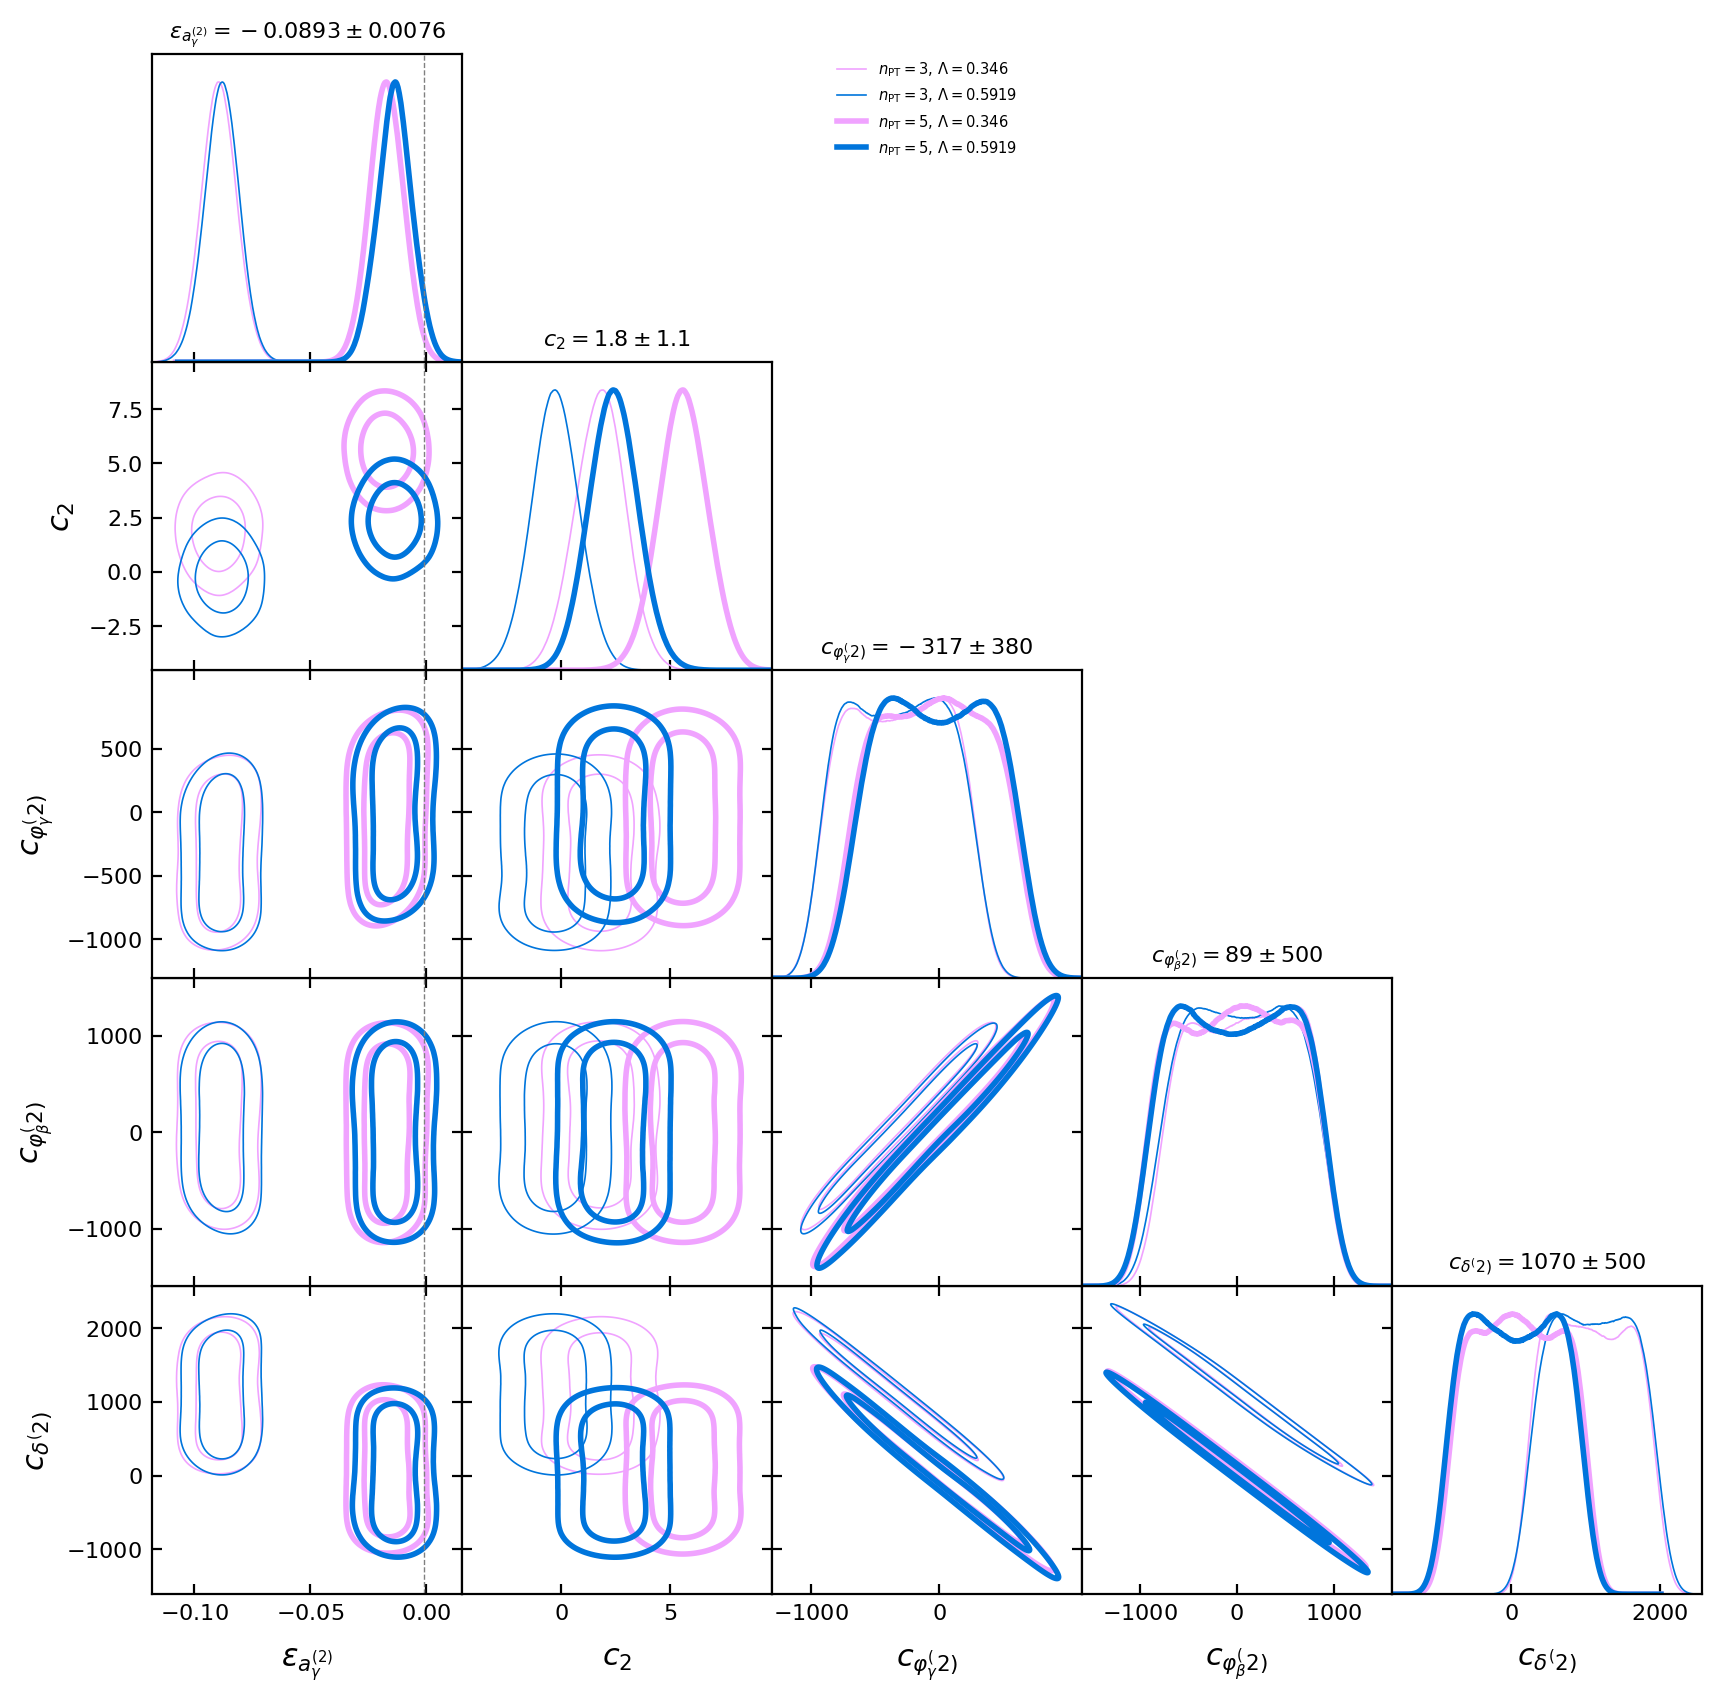

In [31]:
chain_plot_data = {
    "input_files": [],
    "roots": [],
    "legend_labels": [],
    "line_args": [], 
    "contour_args": [],
    **default_triangle_plot
}

for i, (Lambda, chain) in enumerate(zip(Lambdas1, chains1)):
    chain_plot_data["input_files"].append(f"{project_path}/{chain}/{get_input_file_from_chain(chain)}")
    chain_plot_data["roots"].append(loadMCSamples(f"{project_path}/{chain}/chain"))
    chain_plot_data["legend_labels"].append(rf"$n_\text{{PT}}=3$, $\Lambda={Lambda}$")
    chain_plot_data["line_args"].append({"color": colors[i]})
    chain_plot_data["contour_args"].append({"color": colors[i]})

for i, (Lambda, chain) in enumerate(zip(Lambdas2, chains2)):
    chain_plot_data["input_files"].append(f"{project_path}/{chain}/{get_input_file_from_chain(chain)}")
    chain_plot_data["roots"].append(loadMCSamples(f"{project_path}/{chain}/chain"))
    chain_plot_data["legend_labels"].append(rf"$n_\text{{PT}}=5$, $\Lambda={Lambda}$")
    chain_plot_data["line_args"].append({
        "color": colors[i],
        "lw": 2
    })
    chain_plot_data["contour_args"].append({
        "color": colors[i],
        "lw": 2
    })

chain_plot(**chain_plot_data)

# for linking
display(HTML("<div id=\"highder-kmax0.2\"></div>"))

## Individual chains

### Chain 202502251617

In [10]:
input_file = "field-level-inference-GridSPT_input_202502251617.yaml"
output_file = "field-level-inference-GridSPT_output_202502251617"

plotting chain /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202502251617/field-level-inference-GridSPT_input_202502251617.yaml
--- INPUT FOR 202502251617 ---

README: "This is the input file containing all the information about a single execution of the project 'field-level-inference-GridSPT'.""
""
"The file is structured as follows:"
""
"  - `gridspt_fields` contains all the information about the fields generated by GridSPT;"
"  - `nbody_field_input` contains all the information about the fields generated from an N-body simulation;"
"  - `nbody_field_output` contains all the information about the N-body snapshot used to generate N-body fields;"
"  - `chain` contains all the information about the chains or optimizations to be run between N-body fields and GridSPT fields"
"  - `DEBUG` contains the flag to control debugging in the main code"
"  - `RESUME_CHAIN` contains the flag to control resuming of an unfinished chain"
"  - 

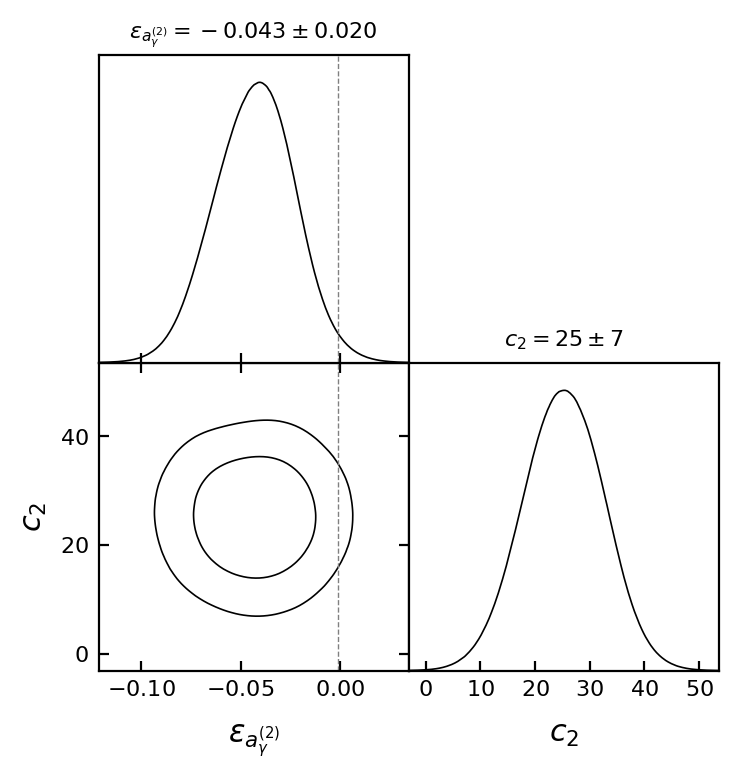

In [11]:
chain_plot_data = {
    "input_files": [f"{project_path}/{output_file}/{input_file}"],
    "roots": [loadMCSamples(f"{project_path}/{output_file}/chain")],
    #"line_args"=[{"color": colors[0]}], 
    #"contour_args"=[{"color": colors[0]}],
    **default_triangle_plot
}

chain_plot(**chain_plot_data)

$c_2 k^2 \delta^{(1)}$

### Tests

In [ ]:
pars = parse_yaml(f"{project_path}/{input_file}")
model_fields = run_chains.load_fields(**pars["gridspt_fields"])
data = generate_fields.load_field(**pars["nbody_field_input"])

 loading field uvz4: 100%
 loading field uvz2: 100%
 loading field phi_betagamma3: 100%
 loading field uv4: 100%
 loading field uv2: 100%
 loading field phi_gammagamma3: 100%
 loading field 1st_delta: 100%
 loading field 3rd_delta: 100%
 loading field phi_gamma2: 100%
 loading field 2nd_delta: 100%


processing uvz4

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


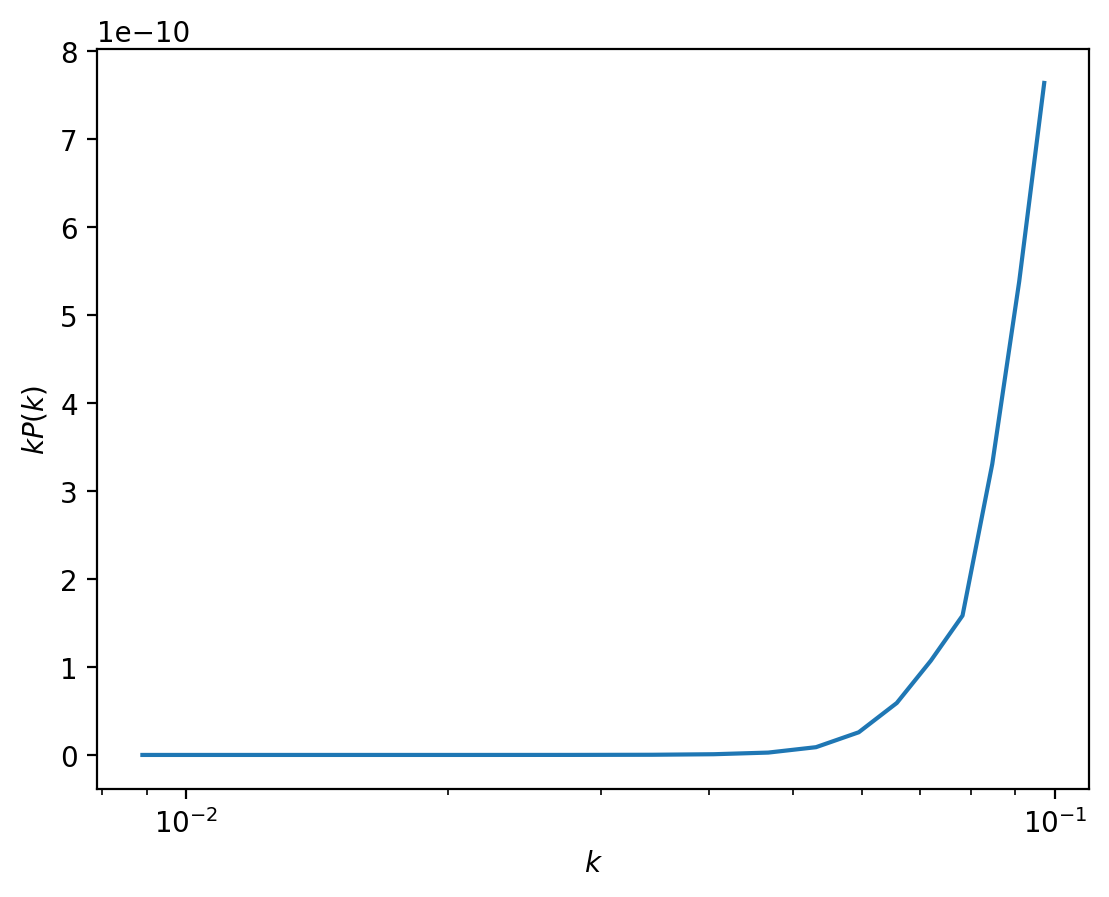

processing uvz2

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


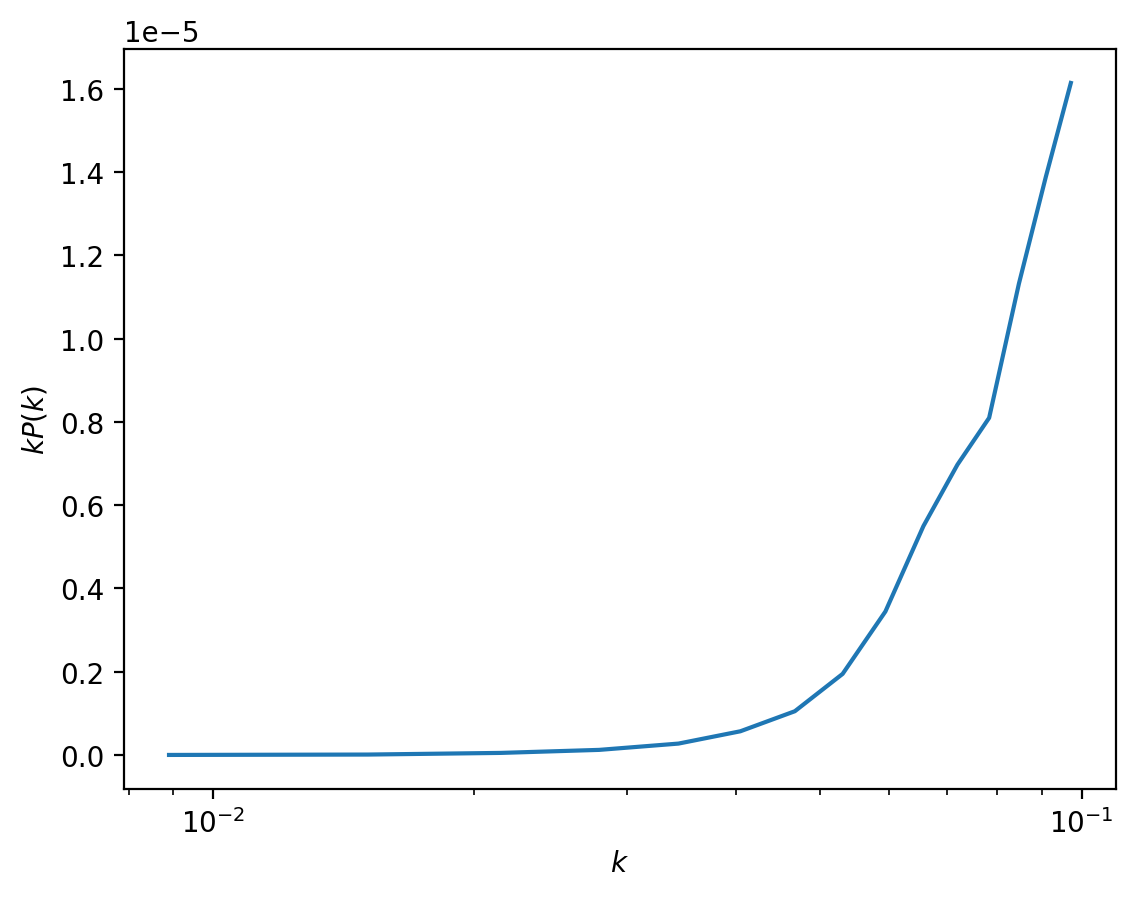

processing phi_betagamma3

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


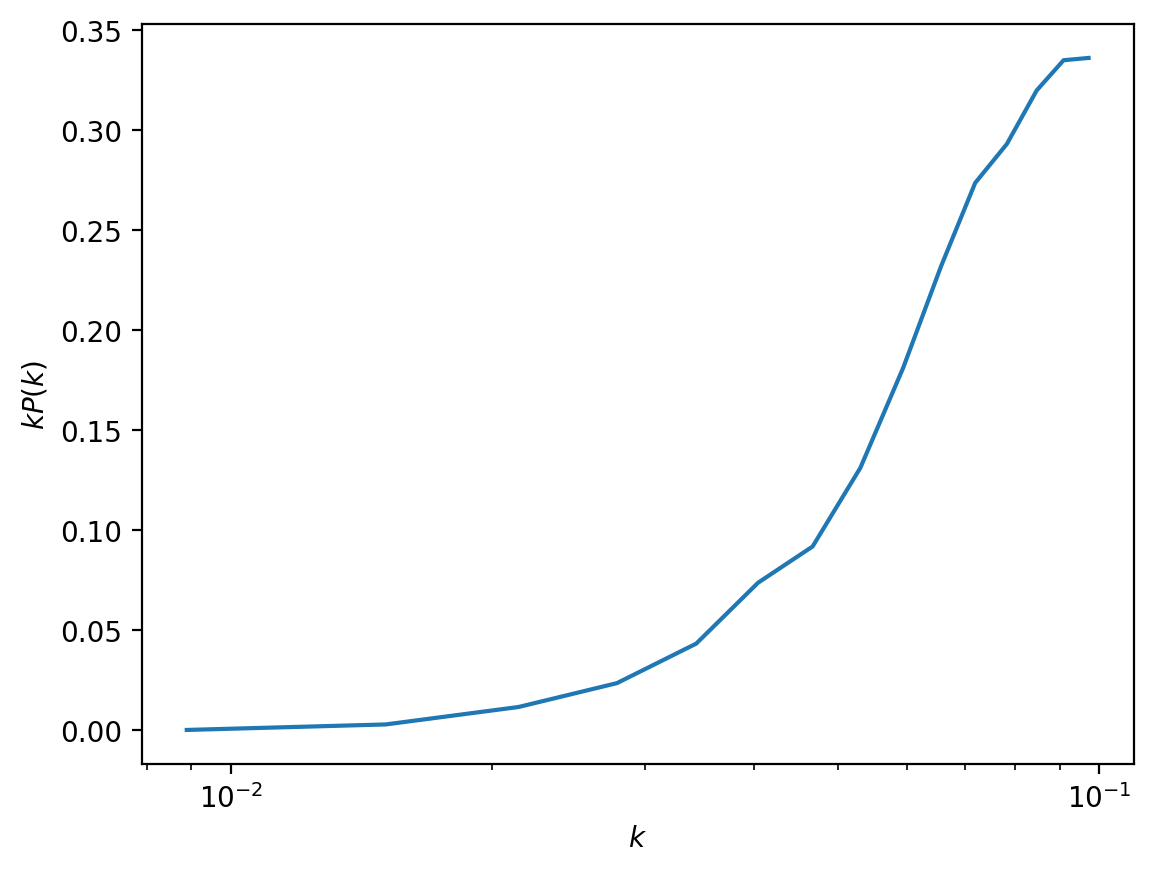

processing uv4

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


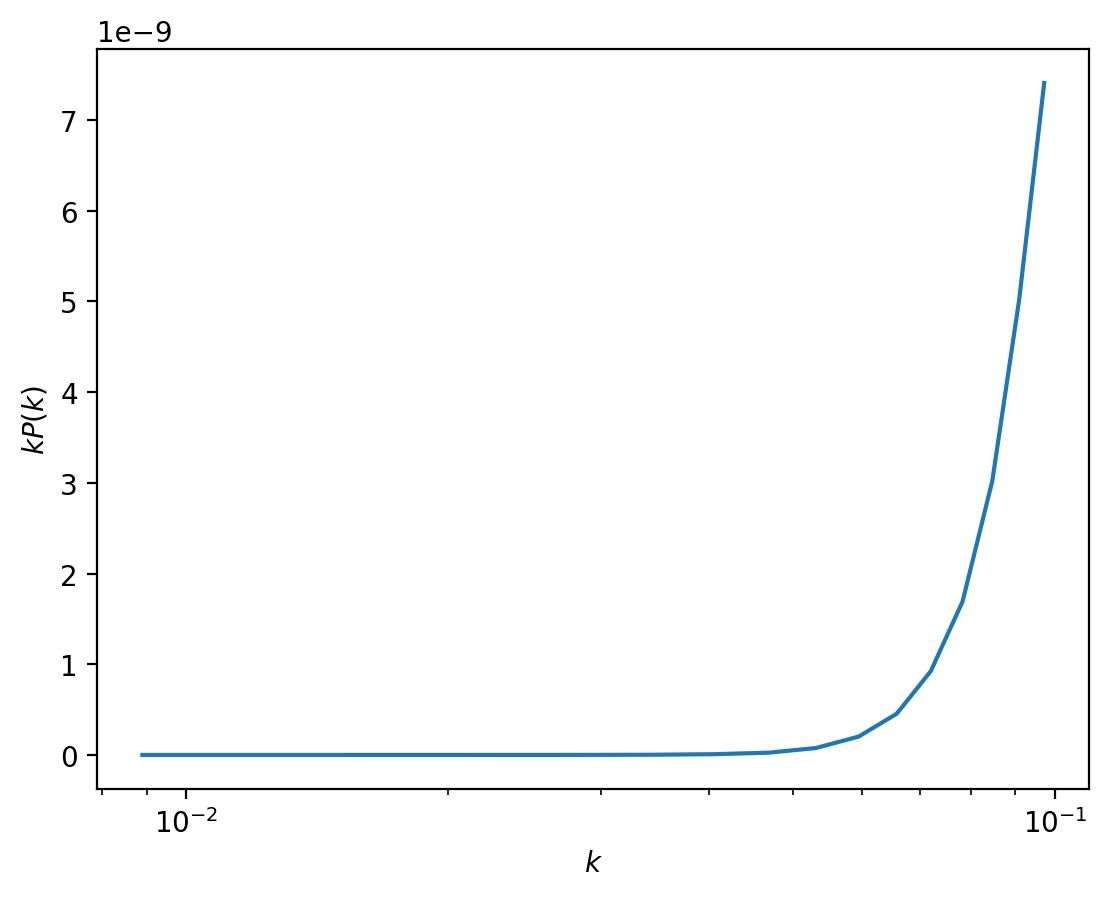

processing uv2

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


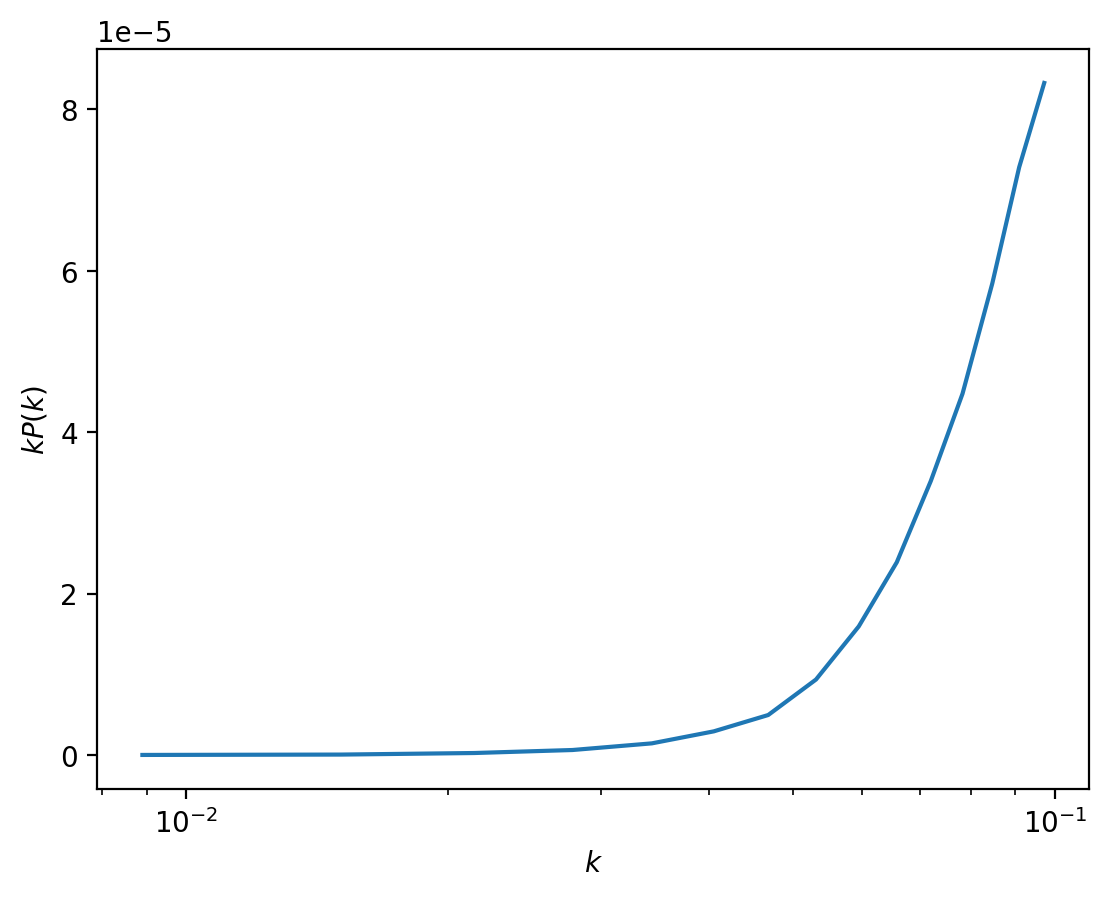

processing phi_gammagamma3

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


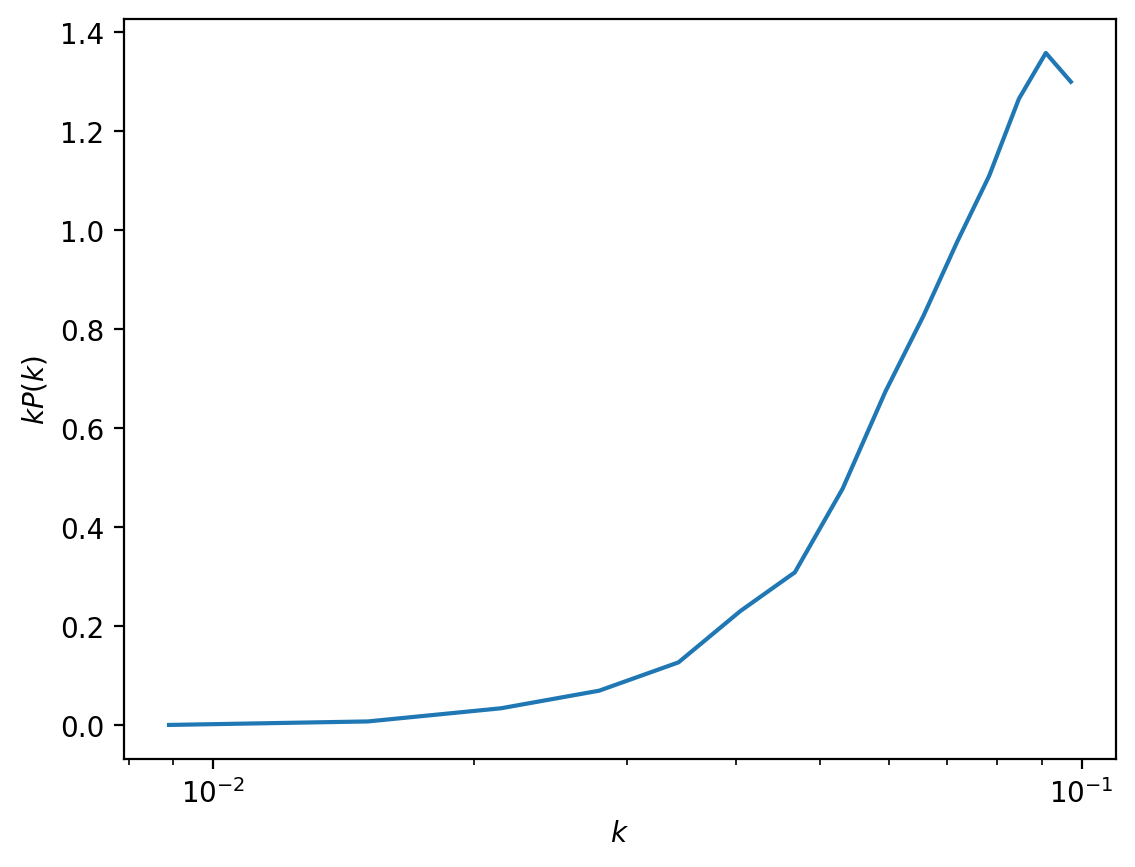

processing 1st_delta

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


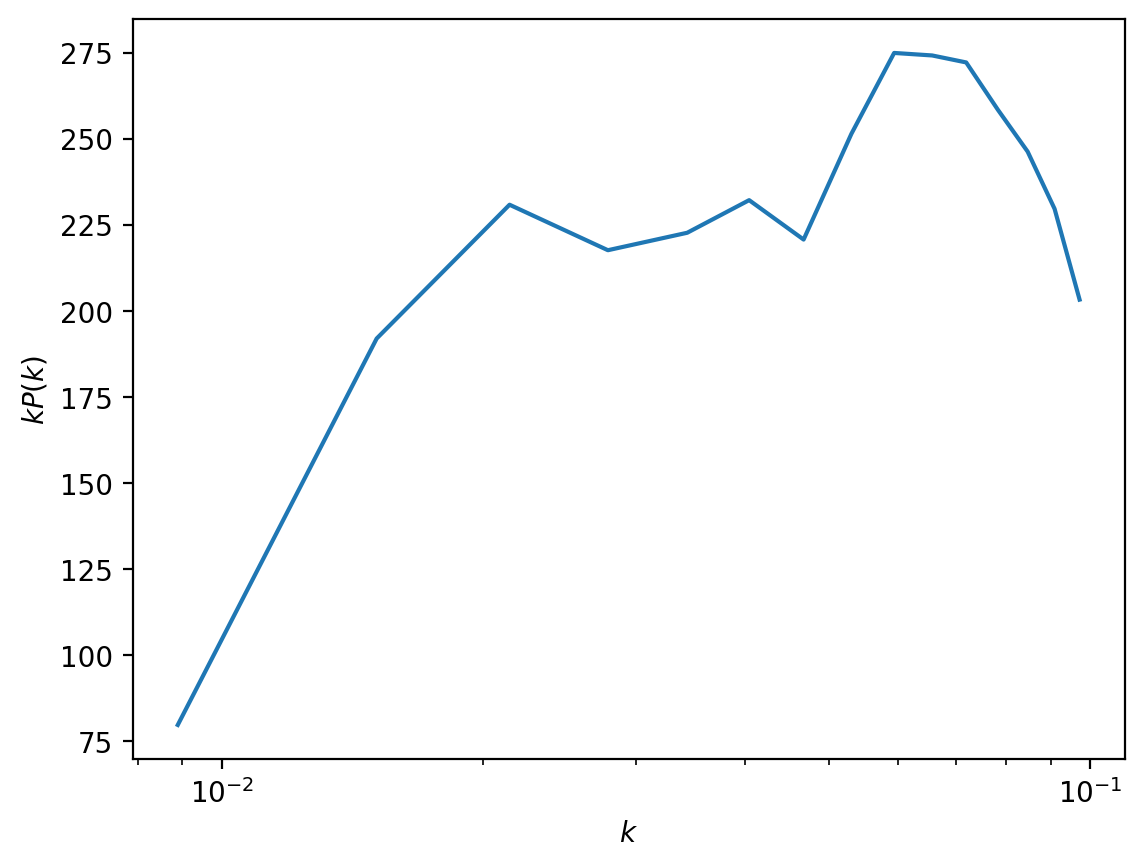

processing 3rd_delta

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


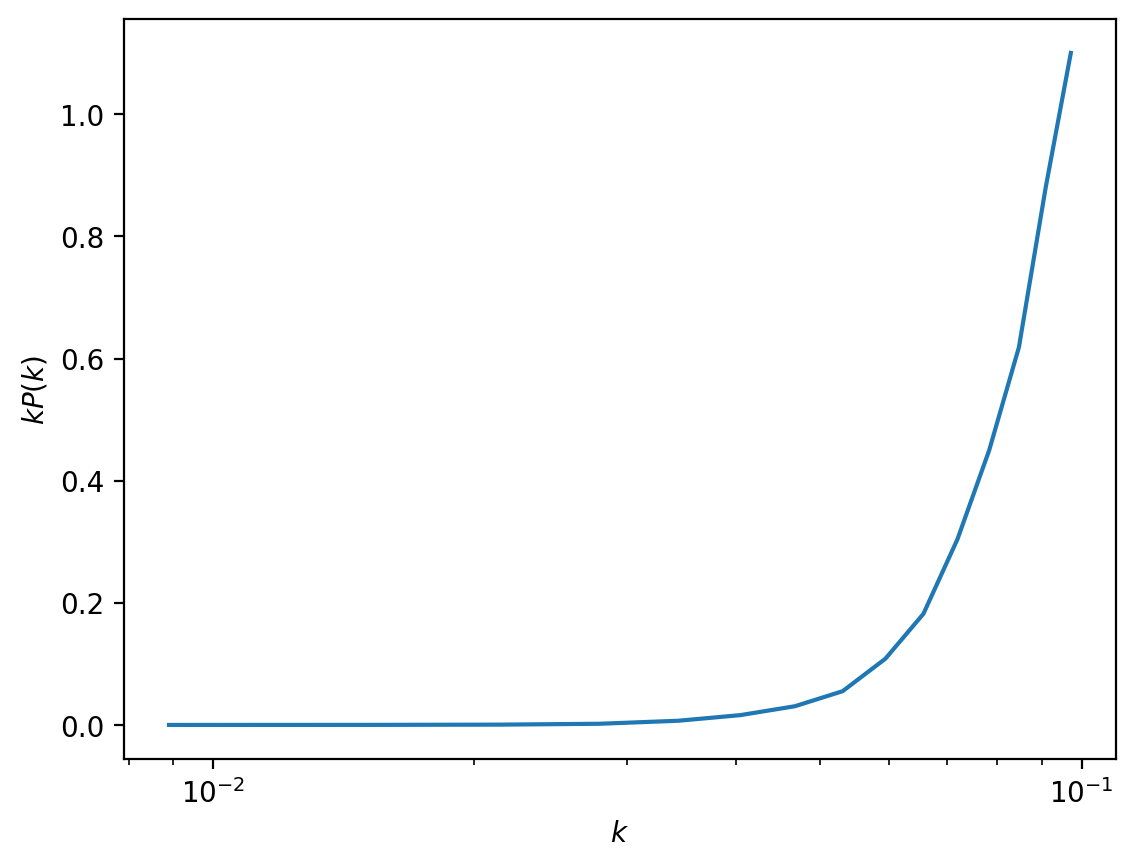

processing phi_gamma2

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


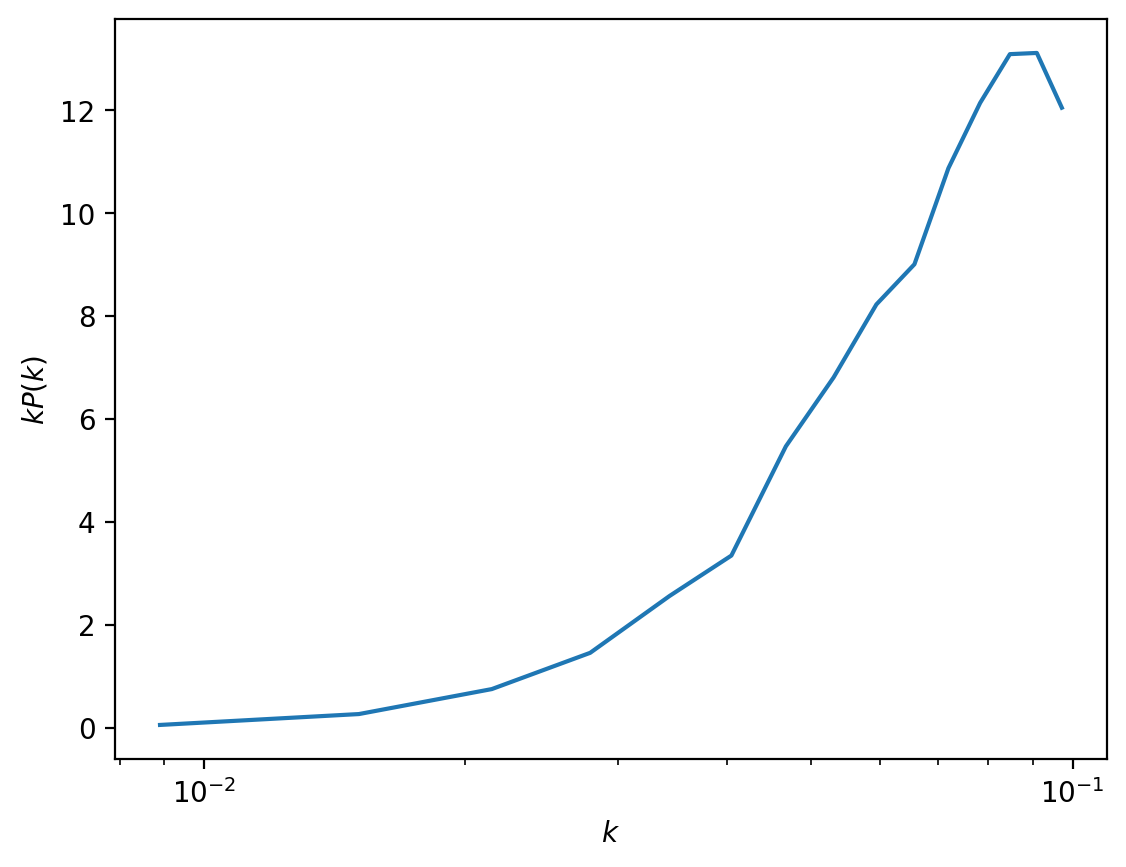

processing 2nd_delta

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


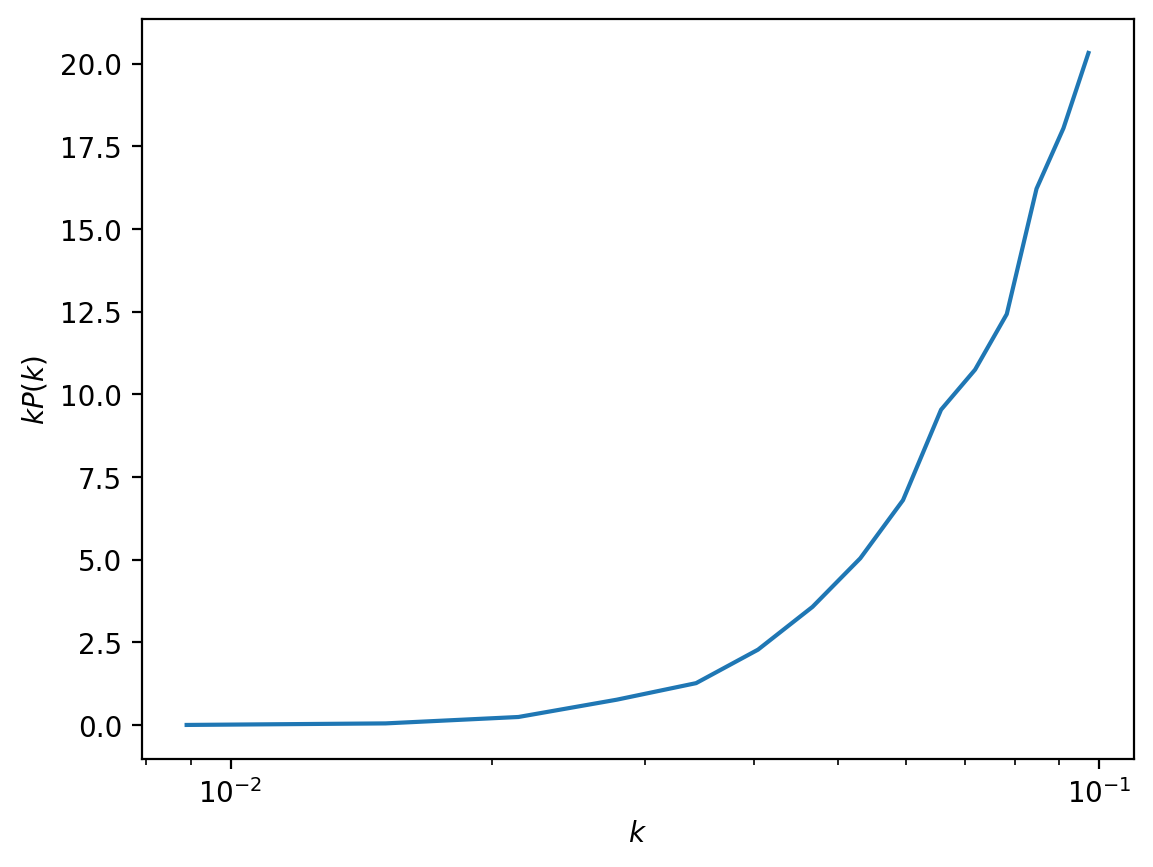

processing nbody

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


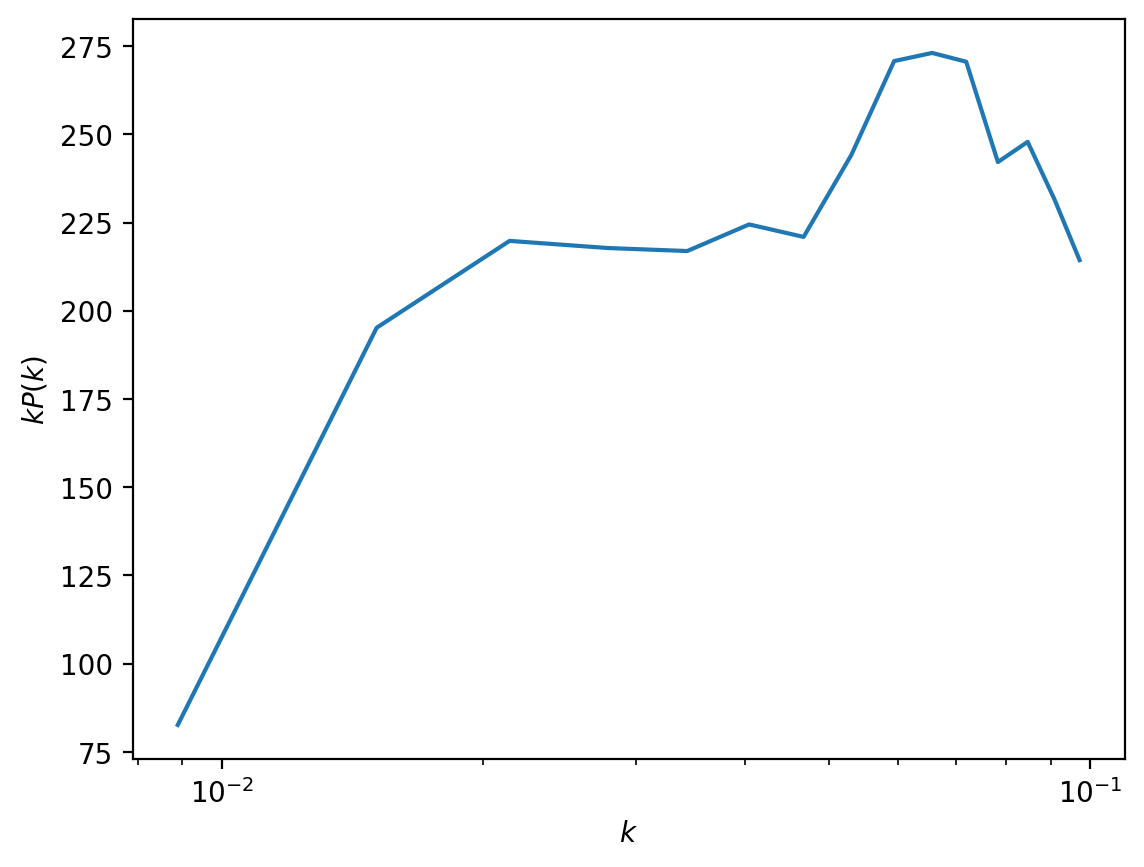

In [ ]:
# plot P(k) of all fields

model_fields["nbody"] = data
kmax = pars["chain"]["kmax"]
Dfac = run_chains.dgrowth_exact(pars["gridspt_fields"]["z"], pars["gridspt_fields"]["Om"])/run_chains.dgrowth_exact(30, pars["gridspt_fields"]["Om"])
for name, field in model_fields.items():
    print(f"processing {name}")
    pk = PKL.Pk(field, 1000, 0, "CIC" if name=="nbody" else "none")
    mask = pk.k3D<=kmax

    if name=="nbody": D, sn = 1, 1/2e-3
    else: sn = 0
    if "uv" in name: D = 1
    if "gamma2" in name: D = Dfac**4
    if "gamma3" in name: D = Dfac**6
    if "1st" in name: D = Dfac**2
    if "2nd" in name: D = Dfac**4
    if "3rd" in name: D = Dfac**6

    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.plot(
        pk.k3D[mask],
        pk.k3D[mask]*(pk.Pk[mask, 0]-sn)*D,
    )
    
    ax.set_xscale("log")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$kP(k)$")

    plt.show()
    

processing 1st_delta

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds
processing nbody

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds
Average deviation within k<=0.06 h/Mpc: 0.01138189269906529


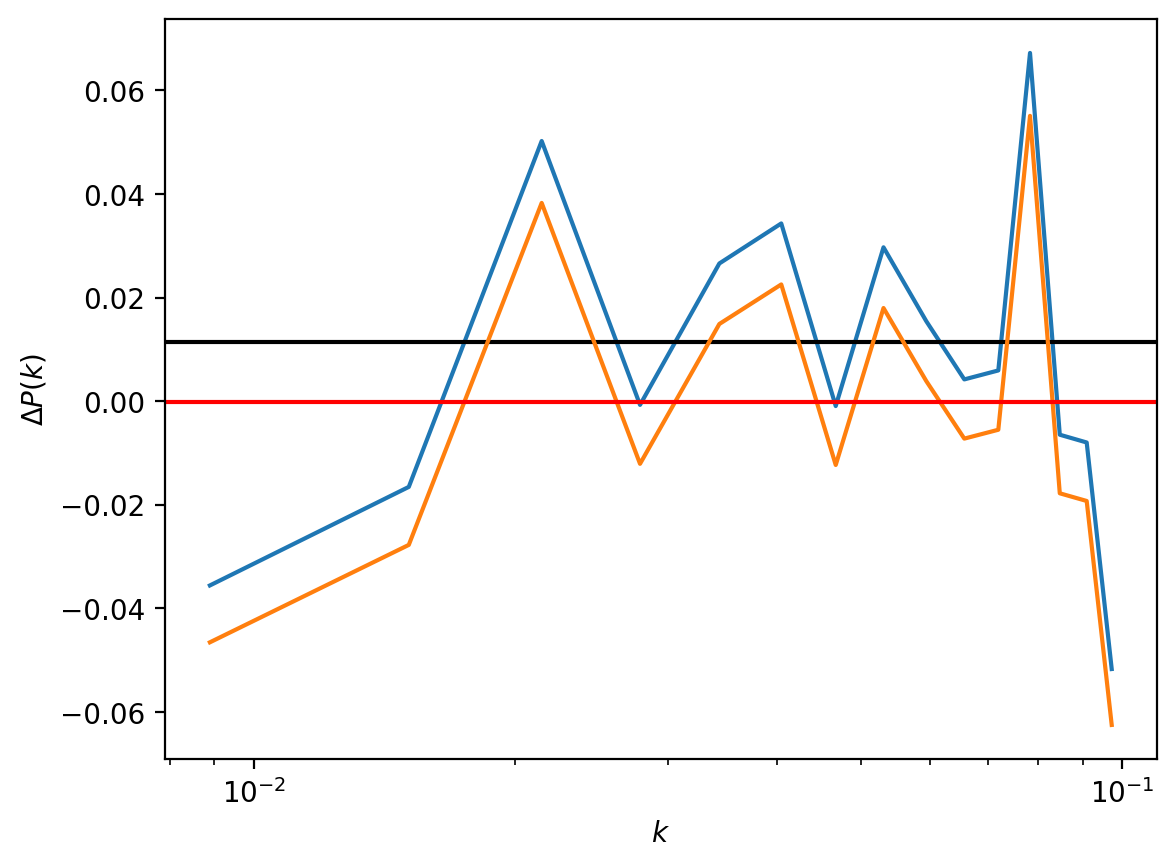

In [ ]:
# plot of linear field vs nbody

model_fields["nbody"] = data
kmax = pars["chain"]["kmax"]
Dfac = run_chains.dgrowth_exact(pars["gridspt_fields"]["z"], pars["gridspt_fields"]["Om"])/run_chains.dgrowth_exact(30, pars["gridspt_fields"]["Om"])
pks = {}
for name, field in model_fields.items():
    if name!="nbody" and name!="1st_delta":
        continue
    
    print(f"processing {name}")
    pk = PKL.Pk(field, 1000, 0, "CIC" if name=="nbody" else "none")
    mask = pk.k3D<=kmax

    if name=="nbody": D, sn = 1, 1/2e-3
    else: sn = 0
    if "uv" in name: D = 1
    if "gamma2" in name: D = Dfac**4
    if "gamma3" in name: D = Dfac**6
    if "1st" in name: D = Dfac**2
    if "2nd" in name: D = Dfac**4
    if "3rd" in name: D = Dfac**6

    pks["k"] = pk.k3D[mask]
    pks[name] = pk.Pk[mask, 0]*D

fig = plt.figure()

ax = fig.add_subplot(111)
deviations = (pks["1st_delta"]-(pks["nbody"]-sn))/(pks["nbody"]-sn)
ax.plot(
    pks["k"],
    deviations,
)
systematic = np.mean(deviations[pks["k"]<=0.06])
ax.axhline(systematic, color="k") # avg deviation within k<=0.06

print(f"Average deviation within k<=0.06 h/Mpc: {systematic}")


deviations = ((1-systematic)*pks["1st_delta"]-(pks["nbody"]-sn))/(pks["nbody"]-sn)
ax.plot(
    pks["k"],
    deviations,
)
systematic = np.mean(deviations[pks["k"]<=0.06])
ax.axhline(systematic, color="r")

ax.set_xscale("log")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\Delta P(k)$")

plt.show()
    

It might be necessary to correct the linear field by $\sqrt{1-0.0114}$. Since higher order are made with products of linear fields, they can be corrected with products of that factor

### Chain 202503031150

In [ ]:
input_file = "field-level-inference-GridSPT_input_202503031150.yaml"
output_file = "field-level-inference-GridSPT_output_202503031150"

/hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031150/chain.txt
Removed no burn in
plotting chain /hpc/home/matteo.peron/projects/field-level-inference-GridSPT/in_out/field-level-inference-GridSPT_output_202503031150/field-level-inference-GridSPT_input_202503031150.yaml
--- INPUT FOR 202503031150 ---

README: "This is the input file containing all the information about a single execution of the project 'field-level-inference-GridSPT'.""
""
"The file is structured as follows:"
""
"  - `gridspt_fields` contains all the information about the fields generated by GridSPT;"
"  - `nbody_field_input` contains all the information about the fields generated from an N-body simulation;"
"  - `nbody_field_output` contains all the information about the N-body snapshot used to generate N-body fields;"
"  - `chain` contains all the information about the chains or optimizations to be run between N-body fields and GridSPT fields"
"  - `DEB

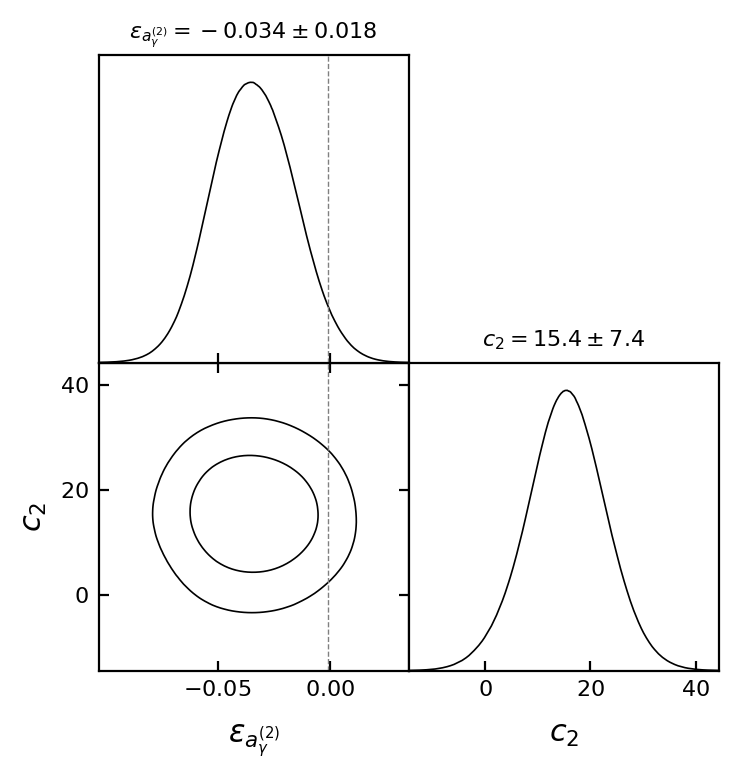

In [ ]:
chain_plot_data = {
    "input_files": [f"{project_path}/{output_file}/{input_file}"],
    "roots": [loadMCSamples(f"{project_path}/{output_file}/chain")],
    #"line_args"=[{"color": colors[0]}], 
    #"contour_args"=[{"color": colors[0]}],
    **default_triangle_plot
}

chain_plot(**chain_plot_data)